In [40]:
import numpy as np
from typing import Optional, Union, List, Dict, Tuple, Callable
from dataclasses import dataclass
import torch
from torch.utils.data import IterableDataset

@dataclass
class Particle:
    vx: float  # vertex x position
    vy: float  # vertex y position
    pt: float  # transverse momentum
    pphi: float  # phi angle of momentum
    charge: int  # particle charge
    particle_id: int  # unique identifier

    def get_track_trajectory(self, t: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Get x,y coordinates along the track for parameter t."""
        # Convert pt to SI units (GeV)
        pt_GeV = self.pt
        
        # Calculate track parameters
        q = self.charge  # Charge in units of e
        B = 2  # Magnetic field in Tesla (typical for detectors)
        R = pt_GeV / (0.3 * B)  # Radius of curvature in meters
        omega = q * 0.3 * B / pt_GeV  # Angular velocity
        
        # Initial position
        x0, y0 = self.vx, self.vy
        
        # Initial velocity components
        vx0 = pt_GeV * np.cos(self.pphi)
        vy0 = pt_GeV * np.sin(self.pphi)
        
        # Helix equations
        x = x0 + R * (np.cos(omega * t + self.pphi) - np.cos(self.pphi))
        y = y0 + R * (np.sin(omega * t + self.pphi) - np.sin(self.pphi))
        
        return x, y

class Detector:
    def __init__(self, min_radius: float = 0.5, max_radius: float = 3.0, n_layers: int = 8):
        """Initialize detector with cylindrical layers."""
        self.layer_radii = np.linspace(min_radius, max_radius, n_layers)
    
    def generate_hits(self, particle: Particle) -> np.ndarray:
        """Generate hits for a particle across detector layers."""
        hits = []
        
        # Sample many points along the track
        t = np.linspace(0, 4*np.pi, 2000)  # Extended range to catch multiple revolutions
        x, y = particle.get_track_trajectory(t)
        r = np.sqrt(x**2 + y**2)
        
        # Find intersections with each layer
        for radius in self.layer_radii:
            # Find all crossings with this radius
            crossings = np.where(np.diff(np.sign(r - radius)))[0]
            
            for idx in crossings:
                # Linear interpolation for better accuracy
                frac = (radius - r[idx]) / (r[idx + 1] - r[idx])
                hit_x = x[idx] + frac * (x[idx + 1] - x[idx])
                hit_y = y[idx] + frac * (y[idx + 1] - y[idx])
                
                # Add if within reasonable bounds
                if abs(hit_x) < 10 and abs(hit_y) < 10:  # Arbitrary cutoff to avoid extreme values
                    hits.append([hit_x, hit_y])
        
        return np.array(hits) if hits else np.zeros((0, 2))

class ParticleGun:
    def __init__(self, 
                 num_particles: Union[int, Tuple[int, int]] = 1,
                 pt_range: Tuple[float, float] = (1.0, 5.0),
                 d0: float = 0.1):
        """Initialize particle gun parameters."""
        self.num_particles = num_particles
        self.pt_range = pt_range
        self.d0 = d0
    
    def get_num_particles(self) -> int:
        """Get number of particles to generate."""
        if isinstance(self.num_particles, int):
            return self.num_particles
        else:
            return np.random.randint(*self.num_particles)
    
    def generate_particles(self, start_pid: int = 0) -> List[Particle]:
        """Generate multiple particles."""
        n_particles = self.get_num_particles()
        particles = []
        
        for i in range(n_particles):
            # Generate vertex position with d0 constraint
            vertex_r = np.random.normal(0, self.d0 / np.sqrt(2))
            vertex_phi = np.random.uniform(-np.pi, np.pi)
            vx = vertex_r * np.cos(vertex_phi)
            vy = vertex_r * np.sin(vertex_phi)
            
            # Generate momentum
            pt = np.random.uniform(*self.pt_range)
            pphi = np.random.uniform(-np.pi, np.pi)
            
            particles.append(Particle(
                vx=vx,
                vy=vy,
                pt=pt,
                pphi=pphi,
                charge=np.random.choice([-1, 1]),
                particle_id=start_pid + i
            ))
        
        return particles

class TrackDataset(IterableDataset):
    def __init__(self, 
                 config: Dict,
                 transforms: Optional[Union[Callable, List[Callable]]] = None):
        """
        Initialize track dataset from configuration.
        
        Args:
            config: Configuration dictionary containing detector and particle gun parameters
            transforms: A transform or list of transforms to apply to each sample
        """
        detector_config = config.get('detector', {})
        self.detector = Detector(
            min_radius=detector_config.get('min_radius', 0.5),
            max_radius=detector_config.get('max_radius', 3.0),
            n_layers=detector_config.get('number_of_layers', 8)
        )
        
        # Create particle guns from config
        self.particle_guns = []
        for gun_config in config.get('particle_guns', []):
            self.particle_guns.append(ParticleGun(
                num_particles=gun_config.get('num_particles', 1),
                pt_range=gun_config.get('pt', [1.0, 5.0]),
                d0=gun_config.get('d0', 0.1)
            ))
        
        self.noise = config.get('noise', None)
        # Handle transforms
        self.transforms = [transforms] if isinstance(transforms, Callable) else transforms
        
    def generate_event(self) -> Dict[str, torch.Tensor]:
        """Generate a single event with particles and their hits."""
        all_hits = []
        all_pids = []
        all_particles = []
        current_pid = 0
        
        # Generate particles from each gun
        for gun in self.particle_guns:
            particles = gun.generate_particles(start_pid=current_pid)
            all_particles.extend(particles)
            current_pid += len(particles)
            
            # Generate hits for each particle
            for particle in particles:
                hits = self.detector.generate_hits(particle)
                if len(hits) > 0:  # Only add if hits were generated
                    all_hits.append(hits)
                    all_pids.extend([particle.particle_id] * len(hits))
        
        # Convert to tensors
        if all_hits:
            hits = torch.tensor(np.concatenate(all_hits), dtype=torch.float32)
            pids = torch.tensor(all_pids, dtype=torch.long)
        else:
            hits = torch.zeros((0, 2), dtype=torch.float32)
            pids = torch.zeros(0, dtype=torch.long)
        
        # Create hit dictionary
        hit_dict = {
            'x': hits,
            'pids': pids,
            'mask': torch.ones(len(hits), dtype=torch.bool)
        }
        
        # Create Event object
        event = None
        
        output = {
            'x': hits,
            'pids': pids,
            'mask': torch.ones(len(hits), dtype=torch.bool),
            'event': event
        }
        
        # Apply transforms if any
        if self.transforms:
            for transform in self.transforms:
                output = transform(output)
        
        return output
    
    def __iter__(self):
        while True:
            yield self.generate_event()


In [43]:
def collate_fn(batch: List[Dict]) -> Dict:
    """
    Collate function for the TrackDataset to be used with DataLoader.
    Pads sequences to the same length within a batch.
    
    Args:
        batch: List of dictionaries containing tensors ('x', 'pids', 'mask')
        
    Returns:
        Dict with batched and padded tensors
    """
    collated = {}
    
    if not batch:
        return {}
        
    # First, check what keys we have
    keys = set(batch[0].keys())
    
    for key in keys:
        if key == 'event':
            # Handle Event objects separately
            collated[key] = [item[key] for item in batch]
            continue
            
        # Get all values for this key, filtering out None
        values = [item[key] for item in batch if item[key] is not None]
        
        if not values:  # If all values were None
            collated[key] = None
            continue
            
        if isinstance(values[0], torch.Tensor):
            if values[0].dim() == 0:  # Scalar tensors
                try:
                    collated[key] = torch.stack(values)
                except:
                    print(f"Error stacking tensors for key {key}")
                    collated[key] = None
            else:  # Tensors with dimensions
                try:
                    collated[key] = torch.nn.utils.rnn.pad_sequence(
                        values, 
                        batch_first=True,
                        padding_value=0
                    )
                except:
                    print(f"Error padding sequences for key {key}")
                    collated[key] = None
        else:
            # For non-tensor data
            collated[key] = values
            
    return collated

# Example usage:
if __name__ == "__main__":
    from torch.utils.data import DataLoader
    import numpy as np
    
    config = {
        'detector': {
            'dimension': 2,
            'hole_inefficiency': 0,
            'layer_safety_guarantee': True,
            'min_radius': 0.5,
            'max_radius': 3.0,
            'number_of_layers': 8
        },
        'particle_guns': [
            {
                'num_particles': 10,
                'pt': [2.5, 2.6],
                'd0': 0.1
            },
            {
                'num_particles': 1,
                'pt': [20, 30],
                'd0': 0.1
            }
        ]
    }
    
    # Example with WedgePatchify transform
    from jepa.utils import WedgePatchify
    
    patchify = WedgePatchify(
        phi_range=np.pi / 4,
        radius_midpoint=(config['detector']['max_radius'] + config['detector']['min_radius']) / 2
    )
    
    dataset = TrackDataset(config)
    dataloader = DataLoader(
        dataset, 
        batch_size=4,
        collate_fn=collate_fn,
        num_workers=0
    )
    
    # Get one batch
    batch = next(iter(dataloader))
    print("Batch shapes:")
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"{key}: {value.shape}")
        elif key == 'event':
            print(f"{key}: list of {len(value)} events")
        else:
            print(f"{key}: {type(value)}")

Batch shapes:
x: torch.Size([4, 88, 2])
event: list of 4 events
pids: torch.Size([4, 88])
mask: torch.Size([4, 88])


In [54]:
import numpy as np
import time
import yaml
import torch
from torch.utils.data import DataLoader
import psutil
import gc
from contextlib import contextmanager

# Old imports
from jepa.utils import WedgePatchify, QualityCut
from toytrack.dataloaders import TracksDataset

# New imports 
# from simplified_tracks import TrackDataset, collate_fn  # Assuming the previous code is saved as simplified_tracks.py

@contextmanager
def track_memory():
    """Context manager to track memory usage."""
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # MB
    yield
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    print(f"Memory change: {mem_after - mem_before:.2f} MB")

def benchmark_dataloader(dataloader, num_batches=100, name="Dataloader"):
    """Benchmark dataloader speed and memory usage."""
    gc.collect()
    torch.cuda.empty_cache()
    
    # Warmup
    for _ in range(3):
        next(iter(dataloader))
    
    # Timing
    start_time = time.time()
    batch_times = []
    batch_sizes = []
    total_hits = 0
    
    with track_memory():
        for i in range(num_batches):
            batch_start = time.time()
            batch = next(iter(dataloader))
            batch_time = time.time() - batch_start
            
            batch_times.append(batch_time)
            batch_sizes.append(batch['x'].shape[0])  # Batch size
            total_hits += batch['x'].nelement()  # Total number of elements
            
            if i % 10 == 0:
                print(f"{name} - Batch {i}: {batch_time:.4f}s")
    
    total_time = time.time() - start_time
    
    # Statistics
    avg_time = np.mean(batch_times)
    std_time = np.std(batch_times)
    avg_batch_size = np.mean(batch_sizes)
    hits_per_second = total_hits / total_time
    
    print(f"\n{name} Statistics:")
    print(f"Average batch time: {avg_time:.4f}s ± {std_time:.4f}s")
    print(f"Average batch size: {avg_batch_size:.1f}")
    print(f"Hits per second: {hits_per_second:.1f}")
    print(f"Total time for {num_batches} batches: {total_time:.2f}s")
    
    return {
        'avg_time': avg_time,
        'std_time': std_time,
        'avg_batch_size': avg_batch_size,
        'hits_per_second': hits_per_second,
        'total_time': total_time
    }

def run_benchmark(config_path='configs/13_testing.yaml', batch_size=3, num_workers=0, num_batches=100):
    print("Loading configuration...")
    config = yaml.load(open(config_path), Loader=yaml.FullLoader)
    
    # Setup for old implementation
    print("\nBenchmarking original implementation...")
    patchify = WedgePatchify(
        phi_range=np.pi / 4, 
        radius_midpoint=(config["dataset_args"]["detector"]["max_radius"] + 
                        config["dataset_args"]["detector"]["min_radius"]) / 2
    )
    # old_dataset = TracksDataset(config["dataset_args"], transforms=patchify)
    old_dataset = TracksDataset(config["dataset_args"])
    old_dataloader = DataLoader(
        old_dataset, 
        batch_size=batch_size, 
        num_workers=num_workers, 
        collate_fn=old_dataset.collate_fn
    )
    old_stats = benchmark_dataloader(old_dataloader, num_batches, "Original Implementation")
    
    # Setup for new implementation
    print("\nBenchmarking new implementation...")
    new_dataset = TrackDataset(config["dataset_args"])
    new_dataloader = DataLoader(
        new_dataset, 
        batch_size=batch_size, 
        num_workers=num_workers, 
        collate_fn=collate_fn
    )
    new_stats = benchmark_dataloader(new_dataloader, num_batches, "New Implementation")
    
    # Compare results
    print("\nComparison (New vs Original):")
    speedup = old_stats['avg_time'] / new_stats['avg_time']
    hits_improvement = new_stats['hits_per_second'] / old_stats['hits_per_second']
    print(f"Speedup: {speedup:.2f}x")
    print(f"Hits/second improvement: {hits_improvement:.2f}x")
    
    return old_stats, new_stats

if __name__ == "__main__":
    # Run benchmark with different configurations
    print("Running single-process benchmark...")
    old_stats_single, new_stats_single = run_benchmark(num_workers=0)
    
    # print("\nRunning multi-process benchmark...")
    # old_stats_multi, new_stats_multi = run_benchmark(num_workers=4)

Running single-process benchmark...
Loading configuration...

Benchmarking original implementation...
Original Implementation - Batch 0: 0.0759s
Original Implementation - Batch 10: 0.0762s
Original Implementation - Batch 20: 0.0761s
Original Implementation - Batch 30: 0.0494s
Original Implementation - Batch 40: 0.0489s
Original Implementation - Batch 50: 0.0488s
Original Implementation - Batch 60: 0.0485s
Original Implementation - Batch 70: 0.0491s
Original Implementation - Batch 80: 0.0522s
Original Implementation - Batch 90: 0.1014s
Memory change: 0.00 MB

Original Implementation Statistics:
Average batch time: 0.0636s ± 0.0186s
Average batch size: 3.0
Hits per second: 8293.6
Total time for 100 batches: 6.37s

Benchmarking new implementation...
New Implementation - Batch 0: 0.0169s
New Implementation - Batch 10: 0.0148s
New Implementation - Batch 20: 0.0133s
New Implementation - Batch 30: 0.0120s
New Implementation - Batch 40: 0.0109s
New Implementation - Batch 50: 0.0100s
New Implem

In [45]:
config_path='configs/13_testing.yaml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

# Setup for old implementation
patchify = WedgePatchify(
    phi_range=np.pi / 4, 
    radius_midpoint=(config["dataset_args"]["detector"]["max_radius"] + 
                    config["dataset_args"]["detector"]["min_radius"]) / 2
)
old_dataset = TracksDataset(config["dataset_args"], transforms=patchify)
old_dataloader = DataLoader(
    old_dataset, 
    batch_size=4, 
    num_workers=0, 
    collate_fn=old_dataset.collate_fn
)

new_dataset = TrackDataset(config["dataset_args"])
new_dataloader = DataLoader(
    new_dataset, 
    batch_size=4, 
    num_workers=0, 
    collate_fn=collate_fn
)

In [46]:
import matplotlib.pyplot as plt

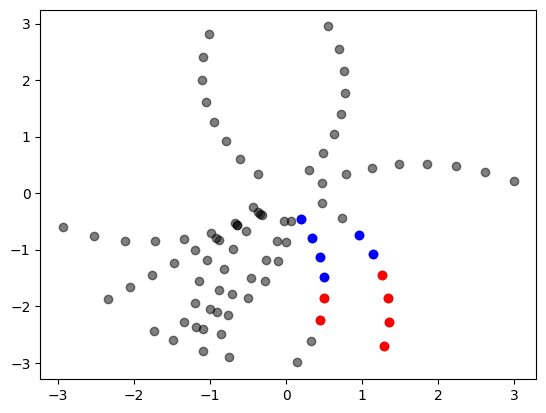

In [47]:
for sample in old_dataset:
    inner_x = sample["x"][sample["context_mask"]]
    outer_x = sample["x"][sample["target_mask"]]

    plt.scatter(sample["x"][:, 0], sample["x"][:, 1], color="black", alpha=0.5)
    plt.scatter(inner_x[:, 0], inner_x[:, 1], color="blue")
    plt.scatter(outer_x[:, 0], outer_x[:, 1], color="red")
    plt.show()
    break

In [51]:
sample_old = next(iter(old_dataloader))
sample_new = next(iter(new_dataloader))

In [52]:
sample_old['x'].shape, sample_new['x'].shape

(torch.Size([4, 88, 2]), torch.Size([4, 88, 2]))

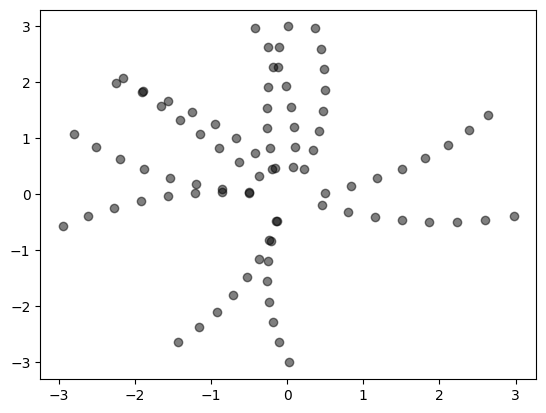

In [53]:
for sample in new_dataset:
    # inner_x = sample["x"][sample["context_mask"]]
    # outer_x = sample["x"][sample["target_mask"]]

    plt.scatter(sample["x"][:, 0], sample["x"][:, 1], color="black", alpha=0.5)
    # plt.scatter(inner_x[:, 0], inner_x[:, 1], color="blue")
    # plt.scatter(outer_x[:, 0], outer_x[:, 1], color="red")
    plt.show()
    break